In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 데이터 로드
df = pd.read_csv('machine.data_update.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0

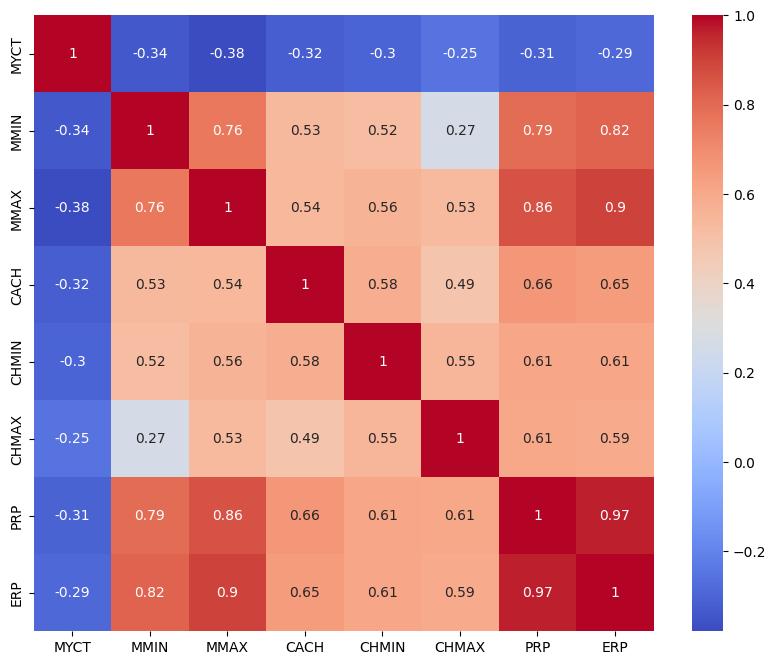

In [2]:
# 데이터 정보 확인
print(df.info())
print(df.describe())

# 숫자형 열만 선택하여 상관관계 행렬 계산
num_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [3]:
# 필요한 변수 선택
X = df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
y = df['PRP']

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 다항 특성 생성
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# 다중 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [4]:
# 학습 데이터 성능 평가
y_train_pred = model.predict(X_train)
train_metrics = {
    'MSE': mean_squared_error(y_train, y_train_pred),
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'R2': r2_score(y_train, y_train_pred)
}
for metric, value in train_metrics.items():
    print(f'Train {metric}: {value}')

# 테스트 데이터 성능 평가
y_test_pred = model.predict(X_test)
test_metrics = {
    'MSE': mean_squared_error(y_test, y_test_pred),
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'R2': r2_score(y_test, y_test_pred)
}
for metric, value in test_metrics.items():
    print(f'Test {metric}: {value}')



Train MSE: 13586.763473053892
Train MAE: 88.02694610778443
Train R2: 0.2932561001867845
Test MSE: 66863.89732142857
Test MAE: 158.1845238095238
Test R2: -0.31345571670075567


In [5]:
# 라쏘 모델을 위한 하이퍼파라미터 튜닝
lasso = Lasso(max_iter=10000)
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f'최적의 하이퍼파라미터: {grid_search.best_params_}')


최적의 하이퍼파라미터: {'alpha': 10}


In [6]:
# 최적의 모델로 예측 및 평가
best_lasso = grid_search.best_estimator_

y_train_pred_lasso = best_lasso.predict(X_train)
y_test_pred_lasso = best_lasso.predict(X_test)

train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)
print(f'Train R² (Lasso): {train_r2_lasso}')
print(f'Test R² (Lasso): {test_r2_lasso}')



Train R² (Lasso): 0.921892721236496
Test R² (Lasso): 0.8894020387599603


In [7]:
# 교차 검증
cv_scores_lasso = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='r2')
print(f"교차 검증 Lasso R² 점수: {cv_scores_lasso}")
print(f"교차 검증 Lasso R² 점수 평균: {cv_scores_lasso.mean()}")


교차 검증 Lasso R² 점수: [0.60863247 0.7755072  0.60689653 0.80885189 0.90194177]
교차 검증 Lasso R² 점수 평균: 0.7403659705683344


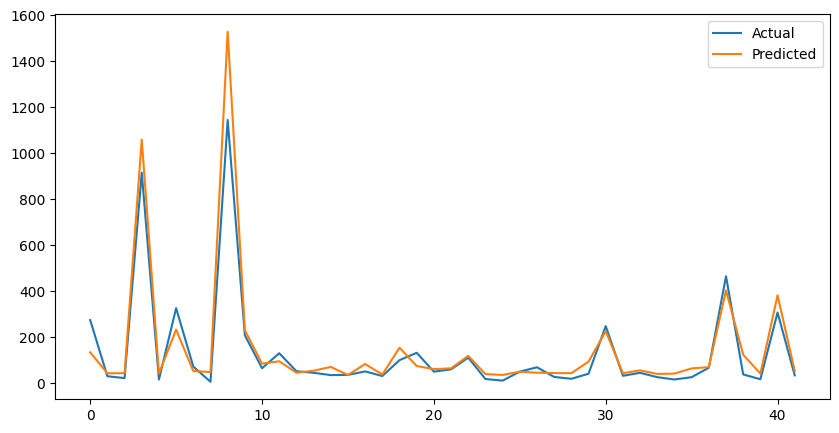

In [8]:
# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred_lasso, label='Predicted')
plt.legend()
plt.show()


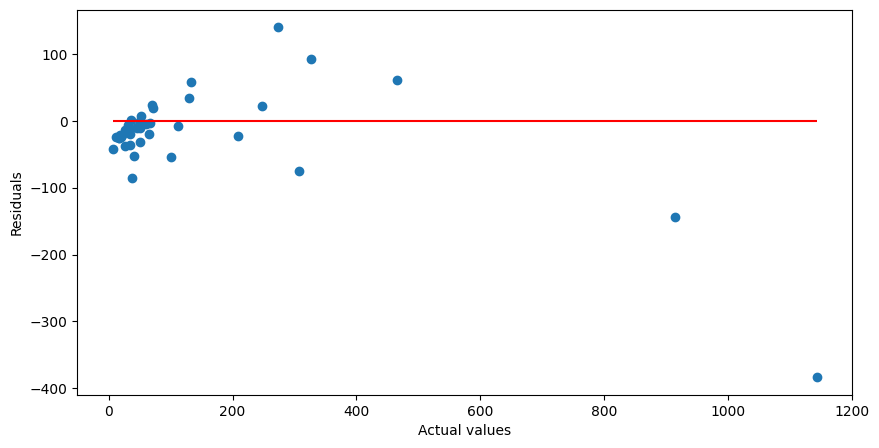

In [9]:
# 잔차 시각화
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test - y_test_pred_lasso)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r')
plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.show()
